# Paneer Cooking Simulation in an Air Fryer Using Python

This simulation models the heat distribution during the cooking of paneer in an air fryer using the heat diffusion equation. We load an image of the paneer, convert it to a binary mask, and simulate heat transfer over time. The heat diffusion properties of the paneer are modeled using Python's `numba` to efficiently solve the heat equation. The result is visualized as a contour plot and an animated GIF showing the cooking process over time.

Inspiration taken from → [Turkey Cooking](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid9.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io, transform
import numba
from numba import jit

In [2]:
# Create a 2D grid with 100x100 points
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

#### Code explanation:

1.   `from google.colab import files`: Imports the files module from the google.colab library, which provides file upload functionality.
2.   `uploaded = files.upload()`: Opens a file picker that allows you to choose one or more files from your local system to upload. The uploaded files are stored in the uploaded variable as a dictionary, with file names as keys and the file data as values.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Paneer.jpg to Paneer (5).jpg


### Code Explanation

1. **Load the uploaded image:**
   ```python
   img = color.rgb2gray(io.imread('Paneer.jpg'))
   ```
   - **`io.imread('Paneer.jpg')`**: This function reads the image file named 'Paneer.jpg' that was uploaded to the Google Colab environment. The file name should match the exact name you used when uploading.
   - **`color.rgb2gray(...)`**: Converts the RGB image to grayscale. This is useful if you want to work with a single channel image, simplifying the subsequent processing.

2. **Resize the image:**
   ```python
   img_resized = transform.resize(img, (100, 100))
   ```
   - **`transform.resize(img, (100, 100))`**: This function resizes the grayscale image to a 100x100 pixel grid, which will match the dimensions of the heat map grid used in the simulation. Resizing is important to ensure that the image data aligns with the model's spatial resolution.

3. **Flip the image:**
   ```python
   img = np.flip(img_resized, axis=0)
   ```
   - **`np.flip(img_resized, axis=0)`**: This function flips the resized image vertically (along the 0-axis). Flipping may be necessary to align the image correctly with the heat map or to reflect the orientation of the object being modeled.

In [4]:
# Load the uploaded image by referencing its file name
img = color.rgb2gray(io.imread('Paneer.jpg'))
# Resize the image to match the 100x100 heat map grid
img_resized = transform.resize(img, (100, 100))
# Flipping the image
img = np.flip(img_resized, axis=0)

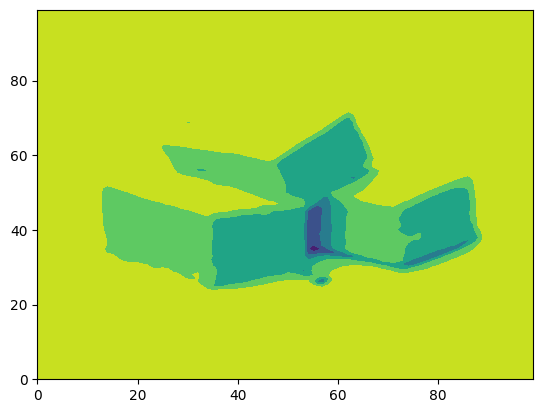

In [5]:
# Initial display of paneer outline
plt.contourf(img)

### Code Explanation

1. **Create a boolean mask for the paneer area:**
   ```python
   paneer_bool = img < 0.9
   ```
   - **`img < 0.9`**: This expression creates a boolean mask (`paneer_bool`) where each pixel in the grayscale image (`img`) is evaluated. If the pixel value is less than 0.9, the corresponding position in `paneer_bool` is set to `True`, indicating that this pixel is considered part of the paneer area. Conversely, pixels with values equal to or greater than 0.9 are set to `False`, indicating they are not part of the paneer.

2. **Modify specific row in the boolean mask:**
   ```python
   paneer_bool[30, :] = False
   ```
   - **`paneer_bool[30, :] = False`**: This line sets all values in row 30 of the `paneer_bool` mask to `False`. This means that the entire row 30 is excluded from the paneer area, which might be necessary if this row corresponds to a part of the image that should not be included in the simulation (e.g., an area with a different object or background).

### Code Explanation

1. **Adjust thermal diffusivity for paneer:**
   ```python
   a_paneer = 1.0e-7  # lower than turkey due to higher water content
   ```
   - **`a_paneer = 1.0e-7`**: This variable represents the thermal diffusivity of paneer, which is set to a lower value compared to turkey. The reduced diffusivity is attributed to the higher water content in paneer, affecting how heat spreads through the material. Thermal diffusivity is an important parameter in heat transfer, as it indicates how quickly a material can conduct heat relative to its capacity to store heat.

2. **Set initial and air fryer temperatures:**
   ```python
   raw_paneer_temp = 273.15 + 25  # Room temperature paneer (25°C)
   airfryer_temp = 273.15 + 180   # Air fryer set to 180°C
   ```
   - **`raw_paneer_temp = 273.15 + 25`**: This line calculates the initial temperature of the paneer at room temperature (25°C) in Kelvin. The conversion from Celsius to Kelvin is done by adding 273.15.
   - **`airfryer_temp = 273.15 + 180`**: This line sets the air fryer temperature to 180°C in Kelvin.

3. **Initialize the heat map:**
   ```python
   init_heat = np.zeros([100, 100]) + airfryer_temp
   ```
   - **`np.zeros([100, 100]) + airfryer_temp`**: This line creates a 100x100 array (`init_heat`) initialized with the air fryer temperature (180°C in Kelvin). This array represents the initial heat distribution across the grid, where all cells start at the air fryer temperature.

4. **Set initial temperatures for the paneer area:**
   ```python
   init_heat[paneer_bool] = raw_paneer_temp
   ```
   - **`init_heat[paneer_bool] = raw_paneer_temp`**: This line updates the `init_heat` array to set the temperature of the paneer region (defined by the boolean mask `paneer_bool`) to the raw paneer temperature (25°C in Kelvin). This creates a temperature profile where the paneer starts at a lower temperature compared to the surrounding air fryer environment.

In [15]:
# Create a boolean mask for the paneer area
paneer_bool = img < 0.9
# Set the non-paneer area to False
paneer_bool[30,:] = False

In [17]:
# Adjust thermal diffusivity for paneer
a_paneer = 1.0e-7  # lower than turkey due to higher water content

# Set initial and air fryer temperatures
raw_paneer_temp = 273.15 + 25  # Room temperature paneer (25°C)
airfryer_temp = 273.15 + 180   # Air fryer set to 180°C
init_heat = np.zeros([100, 100]) + airfryer_temp
init_heat[paneer_bool] = raw_paneer_temp

### Code Explanation

1. **Plot initial temperature distribution:**
   ```python
   plt.contourf(init_heat)
   ```
   - **`plt.contourf(init_heat)`**: This line generates a filled contour plot of the `init_heat` array, which represents the initial temperature distribution across the 100x100 grid. The `contourf` function creates a visualization where different temperature ranges are displayed using varying colors. This allows for an intuitive understanding of how the initial temperatures are distributed in the cooking environment, highlighting the area of the paneer at a lower temperature compared to the surrounding air fryer environment.

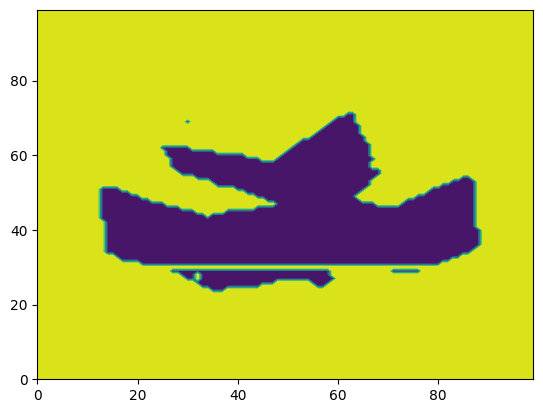

In [18]:
# Plot initial temperature distribution
plt.contourf(init_heat)

### Code Explanation

1. **Simulation parameters:**
   ```python
   times = 36000  # total time in seconds (10 hours)
   ```
   - **`times = 36000`**: This variable defines the total duration of the simulation in seconds. In this case, it is set to 36,000 seconds, which corresponds to 10 hours. This total time represents how long the paneer will be simulated while cooking in the air fryer.

2. **Time intervals for snapshots:**
   ```python
   times_snapshot = 3600  # time intervals for snapshots
   ```
   - **`times_snapshot = 3600`**: This variable sets the time interval for taking snapshots of the heat distribution throughout the simulation. Here, it is set to 3,600 seconds (1 hour). This means that at every hour, the current temperature distribution of the paneer and the surrounding air will be recorded.

3. **Calculate number of frames:**
   ```python
   f = int(times / times_snapshot)
   ```
   - **`f = int(times / times_snapshot)`**: This line calculates the total number of snapshots (frames) that will be taken during the simulation. It divides the total simulation time by the snapshot interval. For a total time of 36,000 seconds and a snapshot interval of 3,600 seconds, `f` will be equal to 10, indicating that 10 frames will be collected throughout the simulation.

4. **Initialize heat frames:**
   ```python
   heat_frames = np.zeros([times_snapshot, 100, 100])
   ```
   - **`heat_frames = np.zeros([times_snapshot, 100, 100])`**: This line initializes a 3D NumPy array named `heat_frames`, which will store the temperature distribution at each snapshot. The array has dimensions corresponding to the number of snapshots (time intervals) and the 100x100 grid size, with each element initialized to zero.

5. **Set the initial heat distribution:**
   ```python
   heat_frames[0] = init_heat
   ```
   - **`heat_frames[0] = init_heat`**: This line assigns the initial heat distribution (`init_heat`) to the first frame of the `heat_frames` array. This sets up the simulation to begin with the previously defined temperature profile, providing a starting point for further calculations in the heat transfer simulation.

In [19]:
# Simulation parameters
times = 36000  # total time in seconds (10 hours)
times_snapshot = 3600  # time intervals for snapshots
f = int(times / times_snapshot)
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

### Code Explanation

1. **Grid size:**
   ```python
   x = 0.5
   ```
   - **`x = 0.5`**: This variable represents a parameter related to the grid size. While the exact role of `x` is not specified in this snippet, it could potentially be used for calculations involving spatial resolution or dimensions relevant to the simulation. It could denote a characteristic size of the cooking area or the individual grid cell.

2. **Grid spacing (dx):**
   ```python
   dx = 0.5 / 100
   ```
   - **`dx = 0.5 / 100`**: This line calculates the grid spacing (the distance between adjacent points in the grid). It divides the total grid size (0.5) by 100, resulting in a grid spacing of 0.005. This small value indicates a fine resolution in the temperature grid, allowing for more accurate modeling of heat distribution and transfer within the paneer as it cooks.

3. **Time step (dt):**
   ```python
   dt = 1
   ```
   - **`dt = 1`**: This variable sets the time step for the simulation, defining the increment of time at which calculations will be performed. In this case, `dt` is set to 1 second, meaning that the simulation will update the heat distribution every second. This choice of time step allows for detailed tracking of temperature changes and heat transfer dynamics over the course of the cooking process.

In [20]:
# Grid and time-step sizes
x = 0.5
dx = 0.5 / 100
dt = 1

### Code Explanation

1. **Function Declaration:**
   ```python
   @numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
   def solve_heat(heatmap, is_paneer):
   ```
   - **`@numba.jit(...)`**: This decorator from the Numba library optimizes the function for performance by compiling it to machine code, allowing for faster execution. The parameters specify the input types and output types of the function.
     - **`f8[:,:,:]`**: The function returns a 3D array of type float64 (double precision).
     - **`b1[:,:]`**: The second parameter, `is_paneer`, is a 2D boolean array indicating the positions of the paneer.
   - **`def solve_heat(heatmap, is_paneer):`**: This is the function definition. It takes two arguments:
     - **`heatmap`**: A 3D array storing the temperature distributions over time.
     - **`is_paneer`**: A boolean mask indicating which grid cells contain paneer.

2. **Initialization:**
   ```python
   cs = heatmap[0].copy()  # current state
   length = len(cs[0])
   cf = 0  # current frame
   ```
   - **`cs = heatmap[0].copy()`**: This line initializes `cs` as a copy of the first time frame in the heatmap, representing the current temperature state.
   - **`length = len(cs[0])`**: Determines the size of one dimension of the heatmap (assuming it is square, `length` will be the number of grid points along one side).
   - **`cf = 0`**: Initializes a counter for the current frame to keep track of how many frames have been updated in the heatmap.

3. **Time Loop:**
   ```python
   for t in range(1, times):
   ```
   - **`for t in range(1, times):`**: This loop iterates over time steps from 1 to `times` (36000 seconds).

4. **State Update:**
   ```python
   ns = cs.copy()  # new state
   for i in range(1, length - 1):
       for j in range(1, length - 1):
           if is_paneer[j][i]:
               a = a_paneer
               ns[j][i] = cs[j][i] + a * dt / dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                       cs[j][i+1] + cs[j][i-1] -\
                                                       4 * cs[j][i])
   ```
   - **`ns = cs.copy()`**: Creates a copy of the current state to calculate the new state.
   - **Nested Loops**: Iterate over each grid cell (excluding the borders) using indices `i` and `j`.
   - **`if is_paneer[j][i]:`**: Checks if the current cell is part of the paneer.
     - If true, calculates the new temperature for that cell based on the heat diffusion equation:
       - **`a = a_paneer`**: Sets `a` to the thermal diffusivity for paneer.
       - The temperature update formula uses the average of the temperatures of the four neighboring cells (`cs[j+1][i]`, `cs[j-1][i]`, `cs[j][i+1]`, `cs[j][i-1]`) and applies the heat diffusion equation.

5. **Updating State and Snapshot:**
   ```python
   cs = ns.copy()
   if t % f == 0:
       cf = cf + 1
       heatmap[cf] = cs
   ```
   - **`cs = ns.copy()`**: Updates the current state to the new state for the next iteration.
   - **`if t % f == 0:`**: Checks if the current time step is a snapshot interval.
     - If true, increments the frame counter (`cf`) and stores the current state in the heatmap at the appropriate frame index.

6. **Return Value:**
   ```python
   return heatmap
   ```
   - **`return heatmap`**: The function returns the updated heatmap containing the temperature distribution over time.

In [21]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_paneer):
    cs = heatmap[0].copy()  # current state
    length = len(cs[0])
    cf = 0  # current frame
    for t in range(1, times):
        ns = cs.copy()  # new state
        for i in range(1, length - 1):
            for j in range(1, length - 1):
                if is_paneer[j][i]:
                    a = a_paneer
                    ns[j][i] = cs[j][i] + a * dt / dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                        cs[j][i+1] + cs[j][i-1] -\
                                                        4 * cs[j][i])
        cs = ns.copy()
        if t % f == 0:
            cf = cf + 1
            heatmap[cf] = cs

    return heatmap

### Code with Comments

```python
# Run the heat equation solver for paneer cooking simulation
heat_frames = solve_heat(heat_frames, paneer_bool)

# Convert temperature from Kelvin to Celsius for better visualization
heat_frames -= 273.15  # Convert back to Celsius for display
```

### Explanation of the Code

1. **Run the Heat Equation Solver:**
   ```python
   heat_frames = solve_heat(heat_frames, paneer_bool)
   ```
   - **`heat_frames = solve_heat(...)`**: Calls the `solve_heat` function, passing the `heat_frames` array (which contains the initial temperature distribution) and the `paneer_bool` boolean mask (indicating where the paneer is located) as arguments.
   - The function executes the heat diffusion simulation for the specified number of time steps and updates the `heat_frames` array with the temperature data over time.

2. **Convert Temperature to Celsius:**
   ```python
   heat_frames -= 273.15  # Convert back to Celsius for display
   ```
   - **`heat_frames -= 273.15`**: Adjusts the temperature values in the `heat_frames` array by subtracting 273.15 to convert temperatures from Kelvin back to Celsius. This conversion is necessary for proper display and interpretation of the temperature data, as the initial temperatures were set in Kelvin during the simulation.

This snippet effectively runs the paneer cooking simulation and prepares the resulting temperature data for visualization in a more intuitive Celsius scale.

In [22]:
# Run the heat equation solver for paneer cooking simulation
heat_frames = solve_heat(heat_frames, paneer_bool)
heat_frames -= 273.15  # Convert back to Celsius for display

### Code with Comments

```python
# Visualization using 'inferno' colormap
my_cmap = plt.get_cmap('inferno')  # Get the 'inferno' colormap for better temperature visualization

plt.figure(figsize=(8, 8))  # Create a new figure with specified size
# Plot a filled contour of the temperature at a specific time frame (frame 1000)
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap,
                 vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
plt.colorbar(a)  # Add a colorbar to indicate the temperature scale
```

### Explanation of the Code

1. **Set Colormap for Visualization:**
   ```python
   my_cmap = plt.get_cmap('inferno')  # Get the 'inferno' colormap for better temperature visualization
   ```
   - **`my_cmap = plt.get_cmap('inferno')`**: Retrieves the 'inferno' colormap from Matplotlib, which is a perceptually uniform colormap suitable for representing temperature data. This colormap provides a clear visual representation of varying temperatures, enhancing the visualization's interpretability.

2. **Create a New Figure:**
   ```python
   plt.figure(figsize=(8, 8))  # Create a new figure with specified size
   ```
   - **`plt.figure(figsize=(8, 8))`**: Initializes a new figure with a specified size of 8 inches by 8 inches. This sets up the canvas for plotting the contour of the temperature data.

3. **Plot the Filled Contour:**
   ```python
   a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap,
                    vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
   ```
   - **`plt.contourf(...)`**: Creates a filled contour plot of the temperature distribution at a specific time frame (frame 1000 in this case).
   - **`heat_frames[1000]`**: Represents the temperature distribution at the 1000th time step of the simulation.
   - **`cmap=my_cmap`**: Applies the previously defined 'inferno' colormap for visual representation.
   - **`vmin` and `vmax`**: Set the minimum and maximum values for the colormap, adjusted from Kelvin to Celsius by subtracting 273.15 from the raw paneer and air fryer temperatures, ensuring that the color mapping reflects the actual temperature range of interest.

4. **Add a Colorbar:**
   ```python
   plt.colorbar(a)  # Add a colorbar to indicate the temperature scale
   ```
   - **`plt.colorbar(a)`**: Adds a colorbar to the plot, providing a reference for the temperature scale used in the filled contour plot. This allows viewers to understand the temperature distribution in the context of the color gradient displayed.

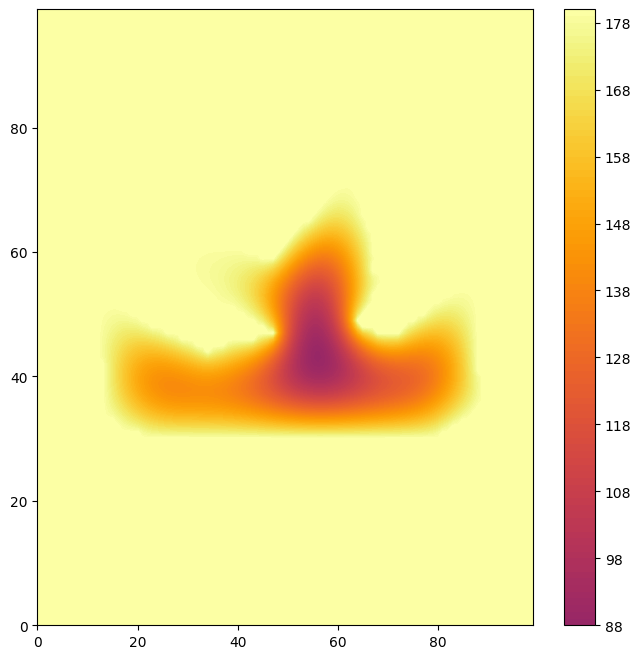

In [23]:
# Visualization using 'inferno' colormap
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8, 8))
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap, vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
plt.colorbar(a)

### Code with Comments

```python
# Animation function for cooking process
def animate(i):
    ax.clear()  # Clear the previous frame's data from the axes
    # Create a filled contour plot for the current frame of heat distribution
    ax.contourf(heat_frames[10 * i], 100, cmap=my_cmap,
                vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
    return fig,  # Return the figure for updating the animation

# Create and save the animation
fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure and axes with specified size
# Generate the animation using the animate function for 359 frames
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)  # Update every 50 milliseconds
# Save the animation as a GIF file named 'paneer_cooked.gif'
ani.save('paneer_cooked.gif', writer='pillow', fps=30)  # Set frames per second to 30
```

### Explanation of the Code

1. **Animation Function Definition:**
   ```python
   def animate(i):
       ax.clear()  # Clear the previous frame's data from the axes
   ```
   - **`def animate(i):`**: Defines the function that will be called for each frame of the animation. The parameter `i` represents the current frame index.
   - **`ax.clear()`**: Clears the axes to remove the previous frame's content. This ensures that the new frame can be drawn without overlapping with the old one.

2. **Create Contour Plot for Current Frame:**
   ```python
   ax.contourf(heat_frames[10 * i], 100, cmap=my_cmap,
                vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
   ```
   - **`ax.contourf(...)`**: Plots a filled contour plot of the heat distribution for the current frame (`10 * i` selects the specific time frame).
   - **`heat_frames[10 * i]`**: Accesses the temperature distribution at the `10 * i` time step. This selection updates every frame to simulate the cooking process.
   - **`cmap=my_cmap`**: Applies the previously defined colormap for the visualization.
   - **`vmin` and `vmax`**: Set the minimum and maximum values for the colormap, converting the temperature values from Kelvin to Celsius.

3. **Return Figure for Animation:**
   ```python
   return fig,  # Return the figure for updating the animation
   ```
   - **`return fig,`**: Returns the updated figure to the animation function. The comma indicates that this is a tuple, which is the expected return type for the animation function.

4. **Create and Save Animation:**
   ```python
   fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure and axes with specified size
   ```
   - **`fig, ax = plt.subplots(figsize=(8, 6))`**: Initializes a new figure and axes for the animation with the specified dimensions.

5. **Generate Animation:**
   ```python
   ani = animation.FuncAnimation(fig, animate,
                                  frames=359, interval=50)  # Update every 50 milliseconds
   ```
   - **`ani = animation.FuncAnimation(...)`**: Creates the animation by repeatedly calling the `animate` function.
   - **`frames=359`**: Specifies the number of frames to be generated for the animation.
   - **`interval=50`**: Sets the time interval between frames in milliseconds.

6. **Save Animation as GIF:**
   ```python
   ani.save('paneer_cooked.gif', writer='pillow', fps=30)  # Set frames per second to 30
   ```
   - **`ani.save('paneer_cooked.gif', writer='pillow', fps=30)`**: Saves the generated animation as a GIF file named 'paneer_cooked.gif' using the Pillow writer, with a frame rate of 30 frames per second.

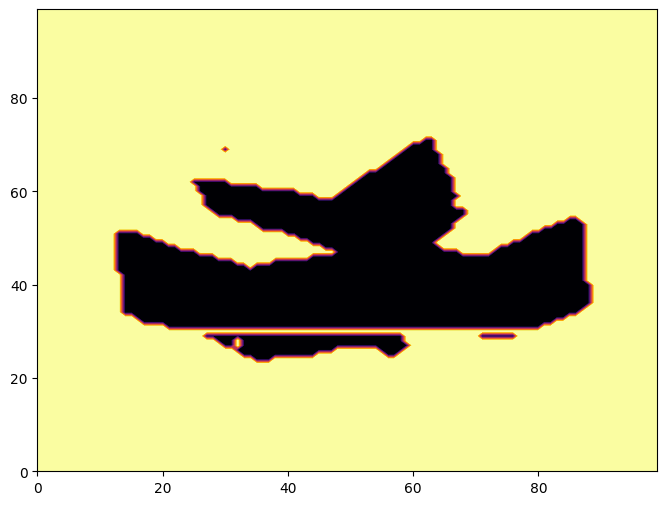

In [24]:
# Animation function for cooking process
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=raw_paneer_temp - 273.15, vmax=airfryer_temp - 273.15)
    return fig,

# Create and save the animation
fig, ax = plt.subplots(figsize=(8, 6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('paneer_cooked.gif', writer='pillow', fps=30)

### Code with Comments

```python
# Create a time array from 0 to 10 hours, matching the length of heat_frames
t = np.linspace(0, 10, len(heat_frames))

# Calculate the average temperature for the paneer over all heat frames
avg_temp = np.array([heat_frame[paneer_bool].mean() for heat_frame in heat_frames])
# Calculate the minimum temperature for the paneer over all heat frames
min_temp = np.array([heat_frame[paneer_bool].min() for heat_frame in heat_frames])
# Calculate the standard deviation of the temperature for the paneer over all heat frames
std_temp = np.array([heat_frame[paneer_bool].std() for heat_frame in heat_frames])

# Plot the average temperature over time
plt.plot(t, avg_temp, label='Average Temperature')
# Plot the minimum temperature over time
plt.plot(t, min_temp, label='Minimum Temperature')
# Draw a horizontal line representing the cooking temperature threshold
plt.axhline(80, color='k', ls='--', label='Cooking Temperature')
# Label the x-axis
plt.xlabel('Time [hours]')
# Label the y-axis
plt.ylabel('Temp [°C]')
# Add a grid to the plot for better readability
plt.grid()
# Show the legend for the plot
plt.legend()
# Display the plot
plt.show()
```

### Explanation of the Code

1. **Time Array Creation:**
   ```python
   t = np.linspace(0, 10, len(heat_frames))
   ```
   - **`np.linspace(0, 10, len(heat_frames))`**: Generates an array of evenly spaced values from 0 to 10 hours, where the number of values corresponds to the number of heat frames in the simulation.

2. **Average Temperature Calculation:**
   ```python
   avg_temp = np.array([heat_frame[paneer_bool].mean() for heat_frame in heat_frames])
   ```
   - **`avg_temp`**: Uses a list comprehension to iterate through each heat frame and calculate the average temperature of the paneer area defined by `paneer_bool`. The result is stored as a NumPy array.

3. **Minimum Temperature Calculation:**
   ```python
   min_temp = np.array([heat_frame[paneer_bool].min() for heat_frame in heat_frames])
   ```
   - **`min_temp`**: Similarly calculates the minimum temperature for the paneer area for each heat frame and stores it as a NumPy array.

4. **Standard Deviation Calculation:**
   ```python
   std_temp = np.array([heat_frame[paneer_bool].std() for heat_frame in heat_frames])
   ```
   - **`std_temp`**: Calculates the standard deviation of the temperatures in the paneer area for each heat frame, storing the results in a NumPy array. (Though this variable is defined, it is not used in the plot below.)

5. **Plotting the Average Temperature:**
   ```python
   plt.plot(t, avg_temp, label='Average Temperature')
   ```
   - **`plt.plot(...)`**: Plots the average temperature against time, labeling the line as "Average Temperature".

6. **Plotting the Minimum Temperature:**
   ```python
   plt.plot(t, min_temp, label='Minimum Temperature')
   ```
   - **`plt.plot(...)`**: Plots the minimum temperature against time, labeling the line as "Minimum Temperature".

7. **Cooking Temperature Line:**
   ```python
   plt.axhline(80, color='k', ls='--', label='Cooking Temperature')
   ```
   - **`plt.axhline(...)`**: Draws a horizontal dashed line at the y-value of 80°C, representing the cooking temperature threshold.

8. **Axes Labels:**
   ```python
   plt.xlabel('Time [hours]')
   plt.ylabel('Temp [°C]')
   ```
   - **`plt.xlabel(...)`** and **`plt.ylabel(...)`**: Label the x-axis as "Time [hours]" and the y-axis as "Temp [°C]".

9. **Adding Grid and Legend:**
   ```python
   plt.grid()  # Add a grid for better readability
   plt.legend()  # Show the legend for the plot
   ```

10. **Displaying the Plot:**
    ```python
    plt.show()  # Display the plot
    ```

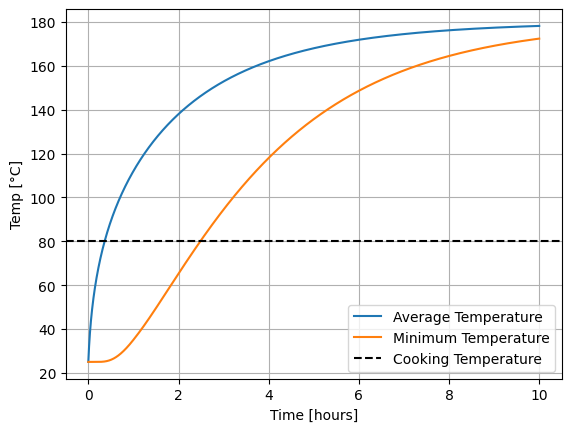

In [25]:
# Plotting temperature evolution over time
t = np.linspace(0, 10, len(heat_frames))
avg_temp = np.array([heat_frame[paneer_bool].mean() for heat_frame in heat_frames])
min_temp = np.array([heat_frame[paneer_bool].min() for heat_frame in heat_frames])
std_temp = np.array([heat_frame[paneer_bool].std() for heat_frame in heat_frames])

plt.plot(t, avg_temp, label='Average Temperature')
plt.plot(t, min_temp, label='Minimum Temperature')
plt.axhline(80, color='k', ls='--', label='Cooking Temperature')
plt.xlabel('Time [hours]')
plt.ylabel('Temp [°C]')
plt.grid()
plt.legend()
plt.show()

In [26]:
!ls


'Paneer (1).jpg'  'Paneer (3).jpg'  'Paneer (5).jpg'	 Paneer.jpg
'Paneer (2).jpg'  'Paneer (4).jpg'   paneer_cooked.gif	 sample_data


In [ ]:
from google.colab import files
files.download('paneer_cooked.gif')